# Defining the model

In [1]:
# only for colab
# ! pip install --upgrade albumentations

In [2]:
import torch
import importlib
from tqdm.notebook import tqdm


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
!nvidia-smi

Thu Dec 16 15:07:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0A:00.0  On |                  N/A |
| 50%   37C    P0    88W / 320W |    897MiB / 10014MiB |     15%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

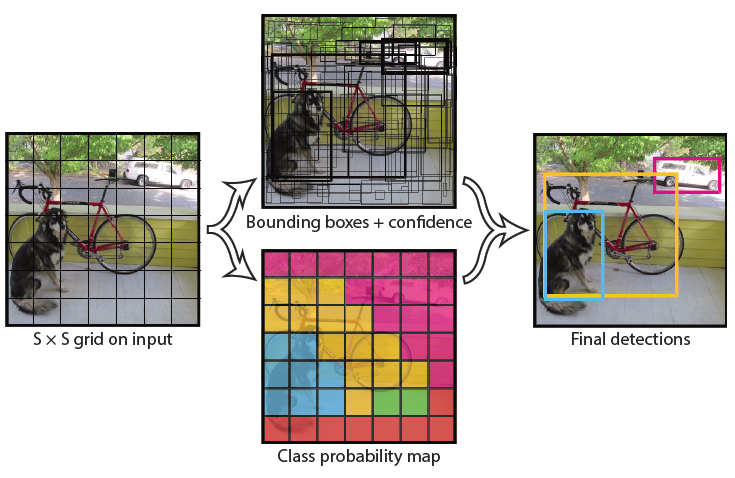

In [4]:
import dataset
import utils
import architecture
import wandb

from torch.optim import SGD
from torch.optim import Adam

In [5]:
wandb.login()

wandb: Currently logged in as: bindas1 (use `wandb login --relogin` to force relogin)


True

## Architecture
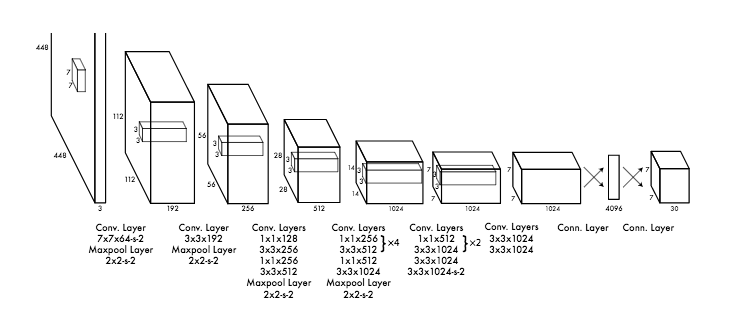

In [6]:
# net = architecture.darknet(batch_norm=True)
# print(net)

## Training

To avoid overfitting:
- dropout is used with rate 0.5 after the first connected layer
- extensive data augmentation is used - random scaling and translations of up to 20% of the original image size
- also randomly adjust the exposure and saturation of the image by up to factor of 1.5 in the HSV color space

### Constants

In [7]:
# from the paper
MOMENTUM = 0.9
EPOCHS = 100
DECAY = 0.0005
# model is trained with 135 epochs
# first 5 epochs from 0.001 to 0.1
# 75 epochs 0.01 epochs
# 30 epochs 0.001
# 30 epochs 0.0001
LEARNING_RATE = 0.000009
LAMBDA_NOOBJ = 0.5
LAMBDA_COORD = 5
SMOOTH = 1e-6

In [8]:
config = dict(
    # TRAINING PARAMS AND HYPERPARAMS
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    optimizer="SGD",
    momentum=MOMENTUM, # only needed for SGD
    # DATASET PARAMS AND HYPERPARAMS
    batch_size=8,
    train_years=[2007, 2012],
    batch_norm=True,
    include_difficult=False,
    transforms=None,
    is_onebatch=False,
    # OTHER PARAMS TO SET
    fc_dropout=0.0, # set value of dropout in fully connected layer for overfitting, 0 means no dropout
    grid_size=7, # in paper this is S
    bounding_boxes=2, # in paper this is B
    classes=20 # in paper this is C
)

Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtest_06-Nov-2007.tar
Extracting ./data/VOCtest_06-Nov-2007.tar to ./data
Feature batch shape for training: torch.Size([8, 3, 448, 448])
Objects batch shape for training: 8
Labels matrix batch shape for training: torch.Size([8, 7, 7, 25])
Size of training set: 16552
Size of test set: 4952
Sample batch for training dataloader is presented below:


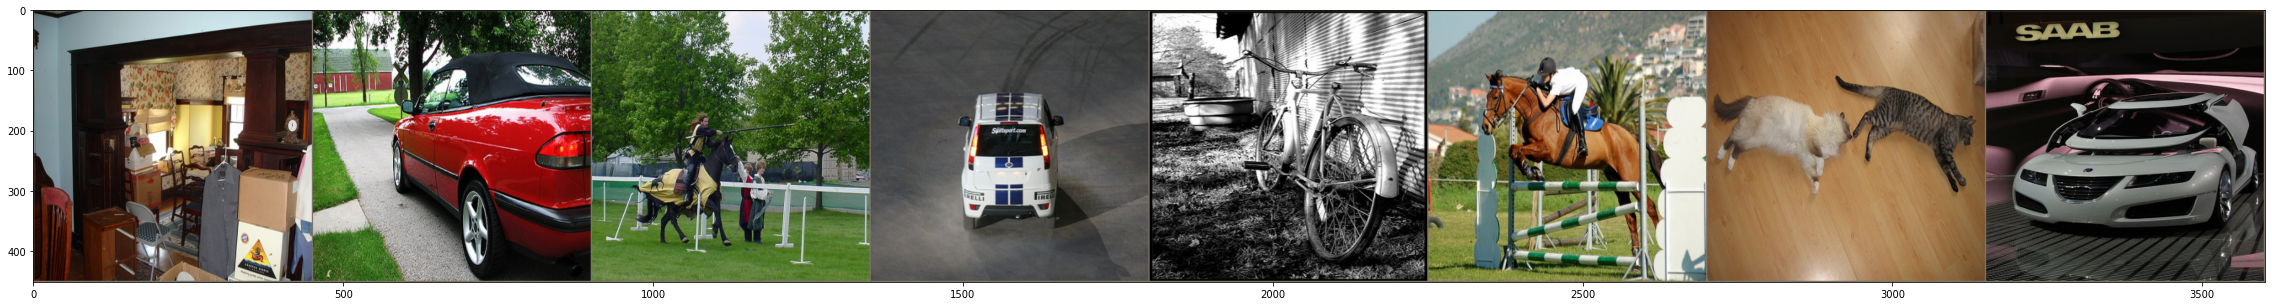

In [9]:
train_dl_predef, test_dl_predef = dataset.prepare_data(config["batch_size"], config["include_difficult"], config["transforms"], config["train_years"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


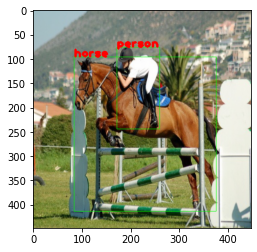

In [10]:
image, labels, _ = iter(train_dl_predef).next()
utils.show_image_with_classes_(image[5], labels[5])

In [11]:
labels[5]

[(172.66666666666669,
  76.3076923076923,
  260.40000000000003,
  244.9230769230769,
  0.0),
 (84.0, 96.0, 376.1333333333333, 413.53846153846155, 5.0)]

### IOU

Implemented in utils.py

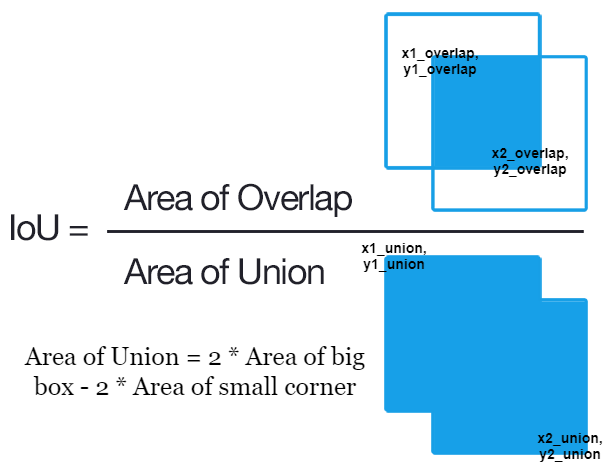

### LOSS

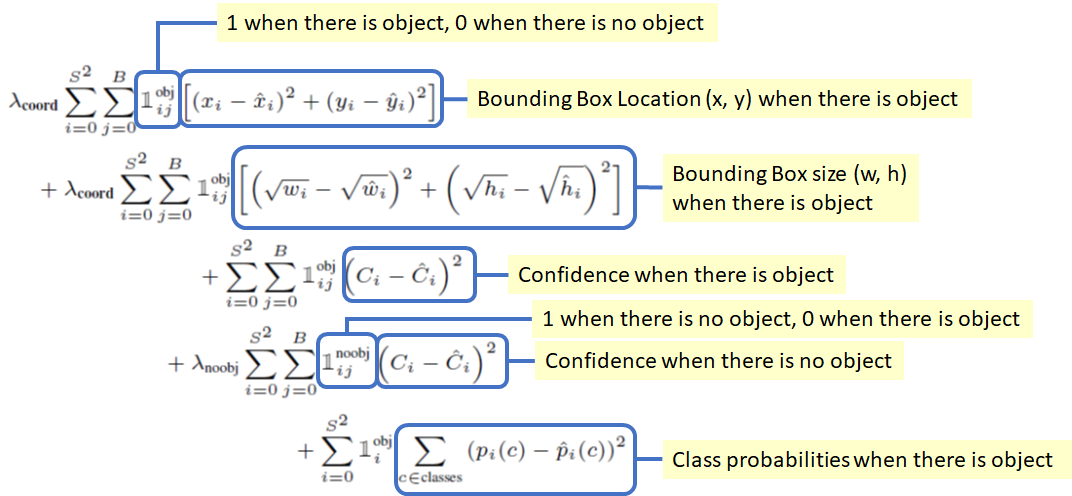

In [12]:
# for details check loss.py

import loss
from loss import YoloLoss

### Training pipeline

In [13]:
import train

## Non-maximal suppression

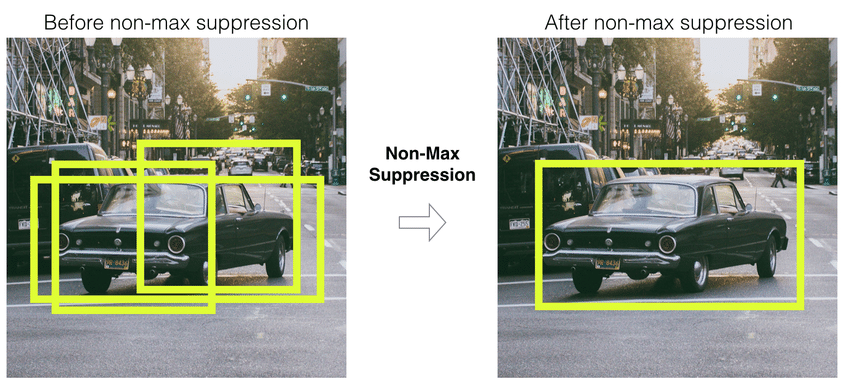

Source: https://www.researchgate.net/figure/Non-Maximal-Suppression_fig5_345061606

For large objects it's hard to tell in which cell they should be localized. Non-maximal suppression is used to fix multiple detecions of one object.

In [14]:
# done in utils.py

## Evaluation (TODO)

In [15]:
def evaluate_model():
    # TODO
    ...

### MAP

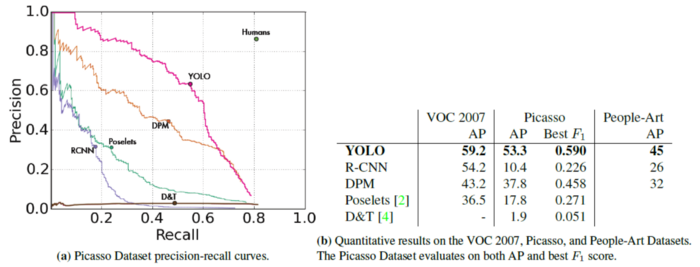

Source: YOLOv1 paper

In [16]:
def mean_average_precision():
  # TODO
    ...

### Precision / recall curve

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

In [17]:
def precision_recall_curve():
    # TODO
    ...

## MAIN

In [18]:
model = train.model_pipeline(config, True, True, train_dl_predef, test_dl_predef)
# model = train.model_pipeline(config, True, False)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/bindas/OneDrive/linux/Documents/0.Inzynierka/YOLO-recreated/train.py:75: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


Average epoch loss 476.56246535572177
Average epoch loss 343.41778827750915
Average epoch loss 205.09605167504313
Average epoch loss 168.4379765658227
Average epoch loss 150.8618770968626
Average epoch loss 123.3734985925718
Average epoch loss 105.05733590017394
Average epoch loss 96.73163722654904
Average epoch loss 84.81886169670916
Average epoch loss 101.46017306389108
Average epoch loss 146.12564991874083
Average epoch loss 173.72593045618282
Average epoch loss 136.10145163292694
Average epoch loss 79.52873496401082
Average epoch loss 84.825578052255
Average epoch loss 122.08964150981141
Average epoch loss 143.87708808383067
Average epoch loss 117.938324952207
Average epoch loss 73.15400374856752
Average epoch loss 36.90184208807252
Average epoch loss 29.022138150608356
Average epoch loss 23.08361566610712
Average epoch loss 19.968454805272376
Average epoch loss 17.23976136991161
Average epoch loss 13.660575314391886
Average epoch loss 10.733696952784868
Average epoch loss 8.280118

avg_batch_loss,█▄▃▂▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
avg_batch_loss,0.00109
epoch,99


In [19]:
# for lr in [0.000001, 0.000005, 0.00001, 0.00005, 0.0001]:
#     model = architecture.darknet()
#     model.to(device)
#     optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
#     #     train_dl, test_dl = dataset.prepare_data()
#     train_dl_main, test_dl_main = train_dl, test_dl
#     one_batch = next(iter(train_dl))
#     train_model(one_batch, model)

In [20]:
one_batch = next(iter(train_dl_predef))
one_batch[2].size()

torch.Size([8, 7, 7, 25])

In [21]:
predictions, targets = utils.pred_and_target_boxes(one_batch, model, single_batch=True)

In [22]:
targets[0]

[0,
 15.0,
 1.0,
 0.4820000231266022,
 0.5173333287239075,
 0.5900000333786011,
 0.797333300113678]

In [23]:
one_batch[0][2].size()

torch.Size([3, 448, 448])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


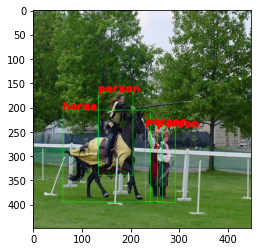

In [24]:
utils.show_image_with_classes_(one_batch[0][2], one_batch[1][2])

In [25]:
classes_dict = {'person': 0, 'bird': 1, 'cat': 2, 'cow': 3, 'dog': 4, 'horse': 5, 'sheep': 6, 'aeroplane': 7,
                'bicycle': 8, 'boat': 9, 'bus': 10, 'car': 11, 'motorbike': 12, 'train': 13, 'bottle': 14,
                'chair': 15, 'dining table': 16, 'potted plant': 17, 'sofa': 18, 'tvmonitor': 19}

inv_classes_dict = {v: k for k, v in classes_dict.items()}
inv_classes_dict[predictions[0][1]]

'chair'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


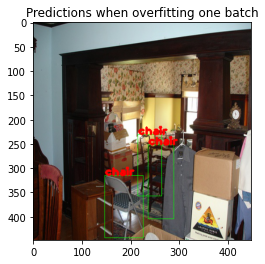

In [31]:
import cv2
import matplotlib.pyplot as plt

FONT = cv2.FONT_HERSHEY_PLAIN
green = (0, 255, 0)
red = (255, 0, 0)
thickness = 1
font_size = 1.5

i=0

un_norm = dataset.DeNormalize(dataset.MEAN, dataset.STD)
# denormalize the image
npimg = un_norm(one_batch[0][i].clone()).numpy()
npimg = npimg.transpose((1, 2, 0)).copy()

for idx, class_no, conf, x, y, x2, y2 in predictions:
    if idx == i:
        x, y, x2, y2 = int(x*448), int(y*448), int(x2*448), int(y2*448)
        cv2.rectangle(npimg, (x, y), (x2, y2), green, thickness)
#         cv2.putText(npimg, "{:.2f}".format(class_no), (x, y), FONT, font_size, red, thickness + 2)
        cv2.putText(npimg, inv_classes_dict[class_no], (x, y), FONT, font_size, red, thickness + 2)
        # cv2.putText(npimg, "{:.3f}".format(conf), (x, y), FONT, font_size, red, thickness + 2)

# Display the image
plt.title("Predictions when overfitting one batch")
plt.imshow(npimg)

In [27]:
utils.save_checkpoint(model)

--- Saving checkpoint ---


### Old pipeline

In [14]:
def train_model(train_dl, model, is_one_batch=False):
    # define the optimization
    criterion = YoloLoss()
    optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    
    # for loss plotting
    loss_values = []
    
    # enumerate epochs
    for epoch in tqdm(range(EPOCHS)):
        if epoch % 10 == 0:
            print(epoch)
        running_loss = 0.0
        
        if not is_one_batch:
        # enumerate mini batches
            for i, (inputs, _, targets) in enumerate(train_dl):
                inputs = inputs.to(device)
                targets = targets.to(device)
                # clear the gradients
                optimizer.zero_grad()
                # compute the model output
                yhat = model(inputs)
                # calculate loss
                loss = criterion(yhat, targets)
                # credit assignment
                loss.backward()
#                 print(loss)
                running_loss =+ loss.item() * inputs.size(0)
                # update model weights
                optimizer.step()
        else:
            # for one batch only
            with torch.autograd.detect_anomaly():
                inputs, targets = train_dl[0].to(device), train_dl[2].to(device)
                optimizer.zero_grad()
                # compute the model output
                yhat = model(inputs)
                # calculate loss
                loss = criterion(yhat, targets)
                # credit assignment
                loss.backward()
                print(loss)
                running_loss =+ loss.item() * inputs.size(0)
                # update model weights
                optimizer.step()
        loss_values.append(running_loss / len(train_dl))
    
    plot_loss(loss_values)

In [16]:
def plot_loss(loss_values):
    plt.plot(loss_values)
    plt.ylabel("YOLO loss")
    plt.xlabel("Epoch")
    plt.title("Loss values during training")

In [17]:
model = architecture.darknet()
model.to(device)
optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
train_dl_main, test_dl_main = train_dl_predef, test_dl_predef
one_batch = next(iter(train_dl_main))
train_model(one_batch, model, is_one_batch=True)

  0%|          | 0/100 [00:00<?, ?it/s]

0
tensor(209.8727, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)


/tmp/ipykernel_17146/447164417.py:34: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


RuntimeError: CUDA out of memory. Tried to allocate 784.00 MiB (GPU 0; 9.78 GiB total capacity; 5.33 GiB already allocated; 695.88 MiB free; 5.86 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF